In [160]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer, LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

Data Processing + Analysis

In [167]:
# Load the dataset
data = pd.read_csv('/Users/yushiyang/desktop/tmdb_5000_movies.csv')

# Convert 'release_date' to year
data['release_year'] = pd.to_datetime(data['release_date']).dt.year

# Select relevant features for clustering
features = ['genres', 'release_year', 'original_language', 'production_countries', 'popularity']

# Preprocess data 
data = data[features]
data['genres'] = data['genres'].apply(lambda x: [genre['name'] for genre in eval(x)])
data['production_countries'] = data['production_countries'].apply(lambda x: [country['name'] for country in eval(x)])

# Calculate the average number of genres associated with each movie
average_num_genres = data['genres'].apply(len).mean()
average_num_companies = data['production_countries'].apply(len).mean()

# Count the number of unique genres and countries
num_unique_genres = data['genres'].explode().nunique()
num_unique_countries = data['production_countries'].explode().nunique()

print("Average number of genres associated with each movie:", average_num_genres)
print("Average number of production companies for each movie:", average_num_companies)
print("Number of unique genres:", num_unique_genres)
print("Number of unique countries:", num_unique_countries)

Average number of genres associated with each movie: 2.53175098896523
Average number of production companies for each movie: 1.3399958359358735
Number of unique genres: 20
Number of unique countries: 88


In [168]:
unique_genres = data['genres'].explode().unique()

print("Unique Genre Values:", unique_genres)

Unique Genre Values: ['Action' 'Adventure' 'Fantasy' 'Science Fiction' 'Crime' 'Drama'
 'Thriller' 'Animation' 'Family' 'Western' 'Comedy' 'Romance' 'Horror'
 'Mystery' 'History' 'War' 'Music' 'Documentary' 'Foreign' 'TV Movie' nan]


In [157]:
unique_countries = data['production_countries'].explode().unique()

print("Unique Country Values:", unique_countries)

Unique Country Values: ['United States of America' 'United Kingdom' 'Jamaica' 'Bahamas'
 'Dominica' 'Czech Republic' 'Poland' 'Slovenia' 'New Zealand' 'Germany'
 'China' 'Canada' 'Italy' 'Japan' 'Malta' 'Australia' 'France' 'Belgium'
 'India' 'Netherlands' 'Spain' 'United Arab Emirates' 'Hong Kong' 'Taiwan'
 'Ireland' 'Morocco' nan 'Hungary' 'Singapore' 'Norway' 'Sweden'
 'South Africa' 'Russia' 'Romania' 'Mexico' 'Monaco' 'Switzerland'
 'Pakistan' 'Malaysia' 'Finland' 'Iceland' 'Denmark' 'Tunisia'
 'Philippines' 'Bulgaria' 'South Korea' 'Brazil' 'Peru' 'Luxembourg'
 'Bosnia and Herzegovina' 'Kazakhstan' 'Portugal' 'Aruba'
 'Libyan Arab Jamahiriya' 'Serbia' 'Ukraine' 'Chile' 'Argentina' 'Panama'
 'Austria' 'Greece' 'Lithuania' 'Cambodia' 'Thailand' 'Slovakia' 'Israel'
 'Fiji' 'Serbia and Montenegro' 'Turkey' 'Nigeria' 'Cyprus' 'Jordan'
 'Bolivia' 'Ecuador' 'Colombia' 'Egypt' 'Bhutan' 'Lebanon'
 'Kyrgyz Republic' 'Algeria' 'Indonesia' 'Guyana' 'Iran' 'Guadaloupe'
 'Afghanistan' 'Angola'

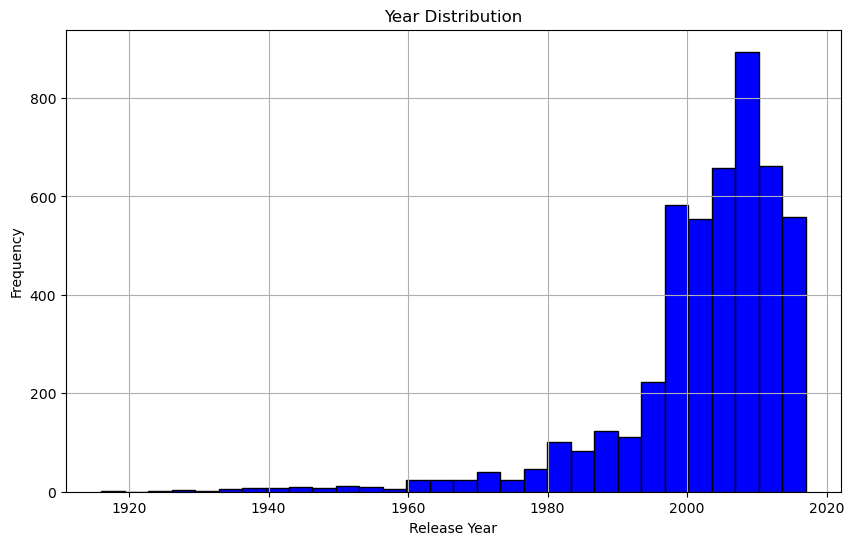

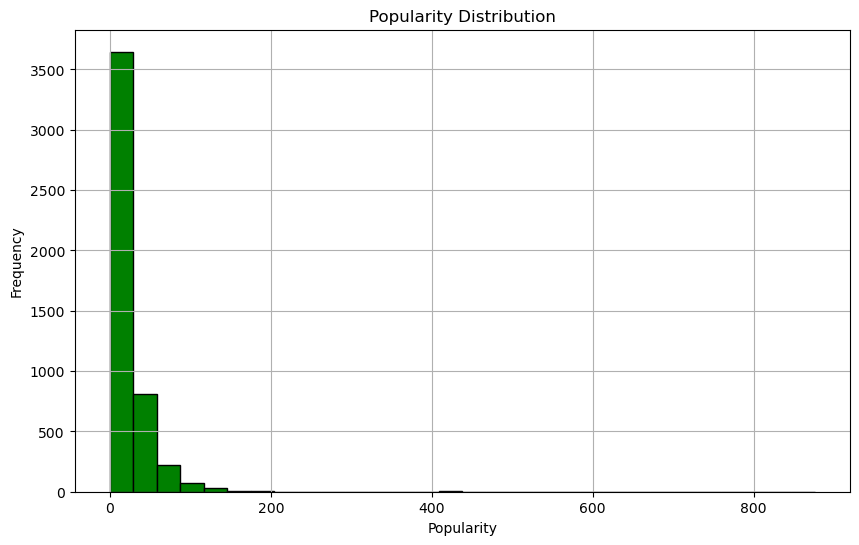

In [80]:
# Plot the year distribution
plt.figure(figsize=(10, 6))
plt.hist(data['release_year'], bins=30, color='blue', edgecolor='black')
plt.title('Year Distribution')
plt.xlabel('Release Year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot the popularity distribution
plt.figure(figsize=(10, 6))
plt.hist(data['popularity'], bins=30, color='green', edgecolor='black')
plt.title('Popularity Distribution')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Feature Processing - One-hot encoding all features

In [169]:
# Break year and popularity into bins and do one-hot encoding
year_bins = [0, 1980, 1990, 2000, 2010, 2020] # Five bins
popularity_bins = [0, 30, 60, 90, 120, 150, 180, 210, float('inf')] # Eight bins

# Create one-hot encoding for year
data_year_band = pd.cut(data['release_year'], bins=year_bins, labels=['<1980', '1980-1990', '1990-2000', '2000-2010', '2010-2020'])

# Create one-hot encoding for popularity
data_popularity_band = pd.cut(data['popularity'], bins=popularity_bins, labels=['0-30', '30-60', '60-90', '90-120', '120-150', '150-180', '180-210', 'above 210'])

# Create one-hot encoding for data_year_band
data_year_onehot = pd.get_dummies(data_year_band, prefix='year_band')

# Create one-hot encoding for data_popularity_band
data_popularity_onehot = pd.get_dummies(data_popularity_band, prefix='popularity_band')

In [170]:
# Convert genre and production company IDs to binary features using one-hot encoding
mlb_genres = MultiLabelBinarizer()
data_genres = pd.DataFrame(mlb_genres.fit_transform(data['genres']), columns=mlb_genres.classes_, index=data.index)

In [171]:
mlb_countries = MultiLabelBinarizer()
data_countries = pd.DataFrame(mlb_countries.fit_transform(data['production_countries']), columns=mlb_countries.classes_, index=data.index)

In [172]:
# Concatenate the one-hot encoded features back to the original data
one_hot_data = pd.concat([data_year_onehot, data_popularity_onehot, data_countries, data_genres], axis=1)
print(one_hot_data.head())

   year_band_<1980  year_band_1980-1990  year_band_1990-2000  \
0                0                    0                    0   
1                0                    0                    0   
2                0                    0                    0   
3                0                    0                    0   
4                0                    0                    0   

   year_band_2000-2010  year_band_2010-2020  popularity_band_0-30  \
0                    1                    0                     0   
1                    1                    0                     0   
2                    0                    1                     0   
3                    0                    1                     0   
4                    0                    1                     0   

   popularity_band_30-60  popularity_band_60-90  popularity_band_90-120  \
0                      0                      0                       0   
1                      0                      0   

In [173]:
print(one_hot_data.columns)

Index(['year_band_<1980', 'year_band_1980-1990', 'year_band_1990-2000',
       'year_band_2000-2010', 'year_band_2010-2020', 'popularity_band_0-30',
       'popularity_band_30-60', 'popularity_band_60-90',
       'popularity_band_90-120', 'popularity_band_120-150',
       ...
       'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western'],
      dtype='object', length=121)


Model - K-means Clustering

In [174]:
# Perform K-means clustering
num_clusters = 50  # Average 100 movies per cluster
kmeans_model = KMeans(n_clusters=num_clusters, random_state=40)
one_hot_data['cluster'] = kmeans_model.fit_predict(one_hot_data)

/Users/yushiyang/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Assign the user to a movie cluster

In [176]:
from collections import Counter

def assign_user_to_cluster(user_watched_movies, kmeans_model, original_columns):
    # Compute the average released year and popularity of movies for that user
    avg_year = sum(movie[0] for movie in user_watched_movies) / len(user_watched_movies)
    avg_popularity = sum(movie[1] for movie in user_watched_movies) / len(user_watched_movies)
    
    # Compute the year band and popularity band for that user
    user_year_band = pd.cut([avg_year], bins=year_bins, labels=['<1980', '1980-1990', '1990-2000', '2000-2010', '2010-2020'])[0]
    user_popularity_band = pd.cut([avg_popularity], bins=popularity_bins, labels=['0-30', '30-60', '60-90', '90-120', '120-150', '150-180', '180-210', 'above 210'])[0]
    
    # Find top 2 major production countries and top 3 major genres
    countries_counter = Counter()
    genres_counter = Counter()
    
    for movie in user_watched_movies:
        countries_counter.update(movie[2])  # Assuming movie[2] contains countries
        genres_counter.update(movie[3])     # Assuming movie[3] contains genres
    
    # Get the top 2 countries and top 3 genres
    top_countries = [country for country, _ in countries_counter.most_common(2)]
    top_genres = [genre for genre, _ in genres_counter.most_common(3)]

    # Encode user summary data manually to the one-hot columns to use by K-means
    user_summary_encoded = []
    for column in original_columns:
        if column.startswith('year_band'):
            user_summary_encoded.append(1 if column == f'year_band_{user_year_band}' else 0)
        elif column.startswith('popularity_band'):
            user_summary_encoded.append(1 if column == f'popularity_band_{user_popularity_band}' else 0)
        else:
            user_summary_encoded.append(1 if column in top_countries or column in top_genres else 0)
    
    print(user_summary_encoded)

    # Predict user cluster based on user summary_encoded
    user_cluster = kmeans_model.predict([user_summary_encoded])[0]
    
    return user_cluster

In [177]:
# Example user watched movies - order is year, popularity, country, genre
user_watched_movies = [
    [2010, 150.0, ['United States'], ['Action', 'Adventure', 'Science Fiction']],
    [2015, 120.0, ['United Kingdom'], ['Action', 'Adventure']],
    [2018, 80.0, ['Canada'], ['Comedy', 'Drama']],
    [2005, 90.0, ['United States'], ['Drama']],
    [2020, 200.0, ['France'], ['Science Fiction']],
    [2012, 110.0, ['Germany'], ['Adventure']],
    [2008, 70.0, ['Australia'], ['Comedy', 'Romance']],
    [2014, 160.0, ['Japan'], ['Animation', 'Fantasy']],
    [2017, 130.0, ['China'], ['Action', 'Fantasy']],
    [2003, 50.0, ['South Korea'], ['Horror', 'Mystery']]
]

original_columns = list(one_hot_data.drop('cluster', axis=1).columns) # Drop the 'cluster' column
user_cluster = assign_user_to_cluster(user_watched_movies, kmeans_model, original_columns)
print("Assigned Cluster for User:", user_cluster)

[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Assigned Cluster for User: 44


/Users/yushiyang/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
